
# .
# Forecasting Hourly Temperature: Deterministic vs. Probabilistic Approaches—A Case Study of Mashhad, Iran
---

In [ ]:
# Standard Libraries
import time
import statistics
import json

# Data Handling and Processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

# Deep Learning with TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, GRU, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import layers, models, regularizers, optimizers


In [ ]:
# Load and preprocess the data
data = pd.read_csv('data.csv')

# Fill missing values using linear interpolation and forward/backward filling
data = data.interpolate(method='linear').ffill().bfill()

# Convert 'date' column to datetime format and set it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Extract temperature data
temp = data['temp']
df = data

# ------------------------------------------
# Feature Engineering for Temperature Forecasting (Next 24 Hours)
# ------------------------------------------

# Create new DataFrame for model input
df_3 = pd.DataFrame({'Temperature': temp})

# Add cyclical time features using sine and cosine transformations
df_3['Seconds'] = df_3.index.map(pd.Timestamp.timestamp)
year = 365.2425 * 24 * 60 * 60  # Convert year to seconds

df_3['Year sin'] = np.sin(df_3['Seconds'] * (2 * np.pi / year))
df_3['Year cos'] = np.cos(df_3['Seconds'] * (2 * np.pi / year))

# Drop the raw seconds column
df_3 = df_3.drop('Seconds', axis=1)

# Append additional meteorological features
feature_columns = [
    'wind_direct', 'wind_speed', 'dew_p', 'p_see', 'p_station',
    'humidity', 'tmin', 'tmax', 'radiation', 'sunny_hours',
    'twet', 'steam_pressure'
]
df_3_ = pd.concat([df_3, df[feature_columns]], axis=1)

# Final copy of the dataset for modeling
df_3_1 = df_3_.copy()


In [3]:

# Ensure 'date' column is datetime and set as index
df_3_1['date'] = pd.to_datetime(df_3_1['date'])
df_3_1.set_index('date', inplace=True)

# ----------------------------
# Parameters
# ----------------------------
WINDOW_SIZE = 16   # Input sequence length
FORECAST_HORIZON = 8  # Number of steps to predict
num_features = df_3_1.shape[1]

# ----------------------------
# Function to create input/output sequences
# ----------------------------
def df_to_X_y(df, window_size=WINDOW_SIZE, forecast_horizon=FORECAST_HORIZON):
    df_np = df.to_numpy()
    X, y = [], []
    for i in range(len(df_np) - window_size - forecast_horizon + 1):
        X.append(df_np[i:i + window_size])
        y.append(df_np[i + window_size:i + window_size + forecast_horizon, 0])  # Predict temperature only
    return np.array(X), np.array(y)

# ----------------------------
# Create sequences
# ----------------------------
X, y = df_to_X_y(df_3_1, WINDOW_SIZE, FORECAST_HORIZON)

# ----------------------------
# Split into train/validation/test sets (70/13.5/16.5 split)
# ----------------------------
total_samples = len(X)
train_end = round(0.7 * total_samples)
val_end = train_end + round(0.135 * total_samples)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# ----------------------------
# Scale features
# ----------------------------
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train.reshape(-1, num_features)).reshape(-1, WINDOW_SIZE, num_features)
X_val_scaled   = feature_scaler.transform(X_val.reshape(-1, num_features)).reshape(-1, WINDOW_SIZE, num_features)
X_test_scaled  = feature_scaler.transform(X_test.reshape(-1, num_features)).reshape(-1, WINDOW_SIZE, num_features)

# ----------------------------
# Scale target (temperature)
# ----------------------------
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled   = target_scaler.transform(y_val)
y_test_scaled  = target_scaler.transform(y_test)

print(f'X3.shape={X3.shape}')
print(f'X3_train.shape={X3_train.shape}')
print(f'X3_val.shape={X3_val.shape}')
print(f'X3_test.shape={X3_test.shape}')

print(f'y3.shape={y3.shape}')
print(f'y3_train.shape={y3_train.shape}')
print(f'y3_val.shape={y3_val.shape}')
print(f'y3_test.shape={y3_test.shape}')

X3.shape=(17520, 16, 15)
X3_train.shape=(12275, 16, 15)
X3_val.shape=(2367, 16, 15)
X3_test.shape=(2878, 16, 15)
y3.shape=(17520, 8)
y3_train.shape=(12275, 8)
y3_val.shape=(2367, 8)
y3_test.shape=(2878, 8)


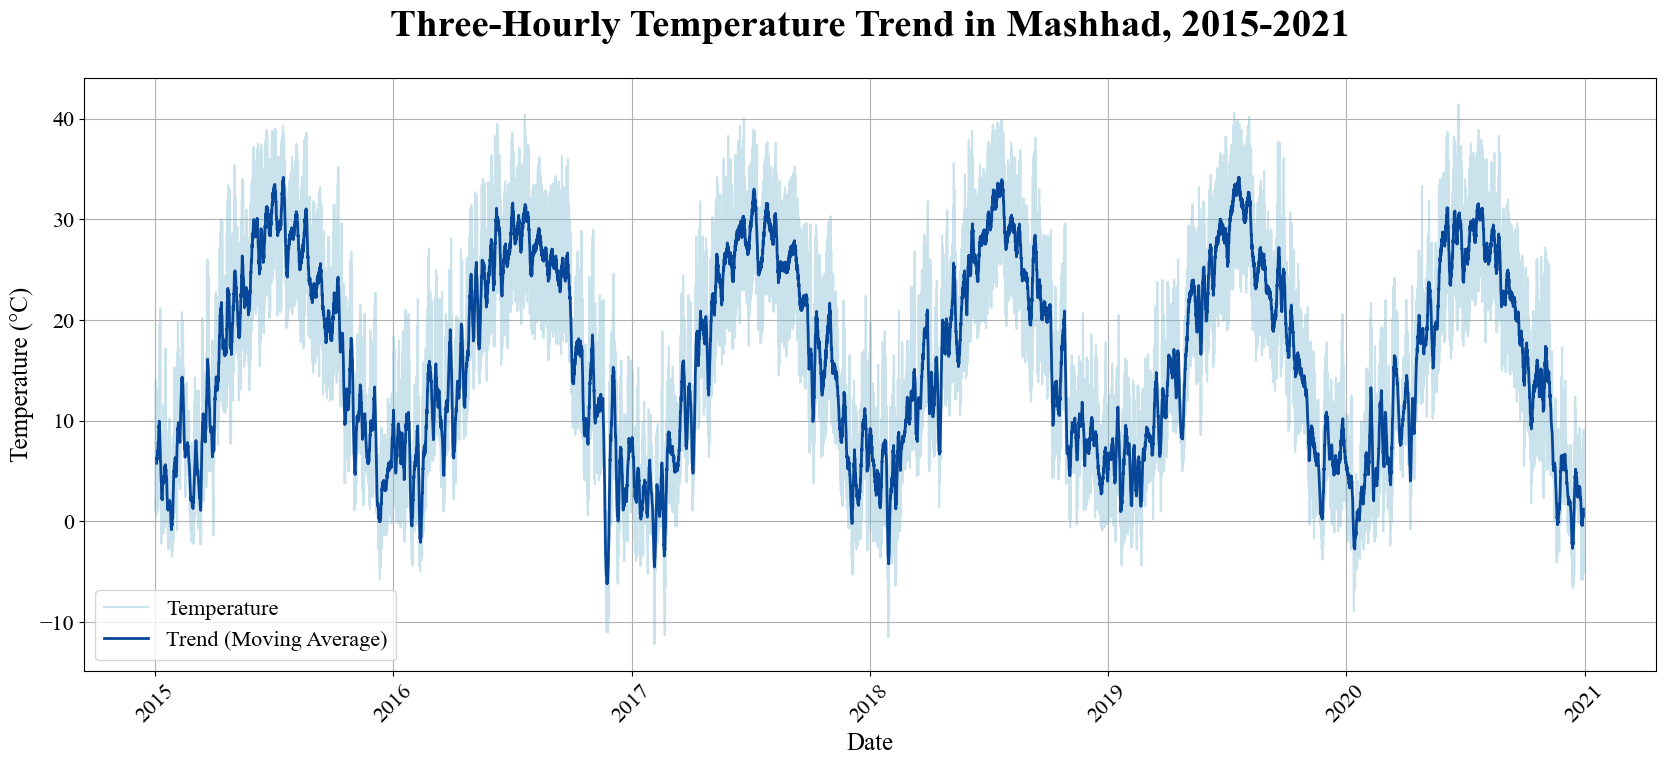

<Figure size 640x480 with 0 Axes>

In [50]:
mpl.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 18,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "legend.fontsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# Extract temperature series from the DataFrame
# Assumes df_3_1 is a DataFrame with a 'Temperature' column
temperature_series = df_3_1['Temperature']

# Ensure the index is in datetime format
temperature_series.index = pd.to_datetime(temperature_series.index)

# Compute a 30-period centered moving average to extract the trend
trend = temperature_series.rolling(window=30, center=True).mean()

plt.figure(figsize=(17, 8))

plt.plot(temperature_series.index, temperature_series.values, 
         label='Temperature', color='#78B7D0', alpha=0.4)

plt.plot(temperature_series.index, trend.values, 
         label='Trend (Moving Average)', color='#074799', linewidth=2)

plt.title('Three-Hourly Temperature Trend in Mashhad (2015–2021)',
          fontsize=28, fontweight='bold', pad=30)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display and save the figure
plt.show()
plt.savefig("temperature_trend.png", dpi=300, bbox_inches='tight', format='png')

---
 # Deterministic Forecast using Standard GRU Model

---

In [5]:
# Load trial hyperparameters
with open("trial.json") as f:
    hp = json.load(f)["hyperparameters"]["values"]

# %%
def build_model_from_trial(hp):
    input_layer = layers.Input(shape=(WINDOW_SIZE, num_features))
    x = layers.GRU(hp['units1'], activation=hp['activation1'],
                   kernel_regularizer=regularizers.l2(hp['l2_reg1']),
                   return_sequences=True)(input_layer)
    x = layers.Dropout(hp['dropout1'])(x)
    x = layers.GRU(hp['units2'], activation=hp['activation2'],
                   kernel_regularizer=regularizers.l2(hp['l2_reg2']))(x)
    x = layers.Dropout(hp['dropout2'])(x)
    x = layers.Dense(hp['dense_units'], activation=hp['dense_activation'])(x)
    output = layers.Dense(8)(x)
    model = models.Model(inputs=input_layer, outputs=output)
    optimizer = {'adam': optimizers.Adam, 'sgd': optimizers.SGD, 'rmsprop': optimizers.RMSprop}[hp['optimizer']]
    model.compile(optimizer=optimizer(learning_rate=hp['learning_rate']),
                  loss='mse', metrics=['mae', 'mse'])
    return model

# %%
model_trial = build_model_from_trial(hp)
model_trial.load_weights("checkpoint.weights.h5")
model_trial.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 15)]          0         
                                                                 
 gru (GRU)                   (None, 16, 160)           84960     
                                                                 
 dropout (Dropout)           (None, 16, 160)           0         
                                                                 
 gru_1 (GRU)                 (None, 224)               259392    
                                                                 
 dropout_1 (Dropout)         (None, 224)               0         
                                                                 
 dense (Dense)               (None, 80)                18000     
                                                                 
 dense_1 (Dense)             (None, 8)                 648   

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers

def build_best_gru_model():
    input_layer = layers.Input(shape=(WINDOW_SIZE, num_features))

    x = layers.GRU(160,
                   activation='relu',
                   kernel_regularizer=regularizers.l2(1.256e-05),
                   return_sequences=True)(input_layer)
    x = layers.Dropout(0.1)(x)

    x = layers.GRU(224,
                   activation='tanh',
                   kernel_regularizer=regularizers.l2(2.736e-04))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(80, activation='relu')(x)

    output = layers.Dense(FORECAST_HORIZON)(x)  
    model = models.Model(inputs=input_layer, outputs=output)

    optimizer = optimizers.Adam(learning_rate=0.000632)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

    return model

model = build_best_gru_model()
model.summary()


In [6]:
history1 = model.fit(X3_train_scaled, y3_train_scaled, epochs=20, validation_data=(X3_val_scaled, y3_val_scaled))
history1


Epoch 1/20
384/384 [==============================] - 24s 51ms/step - loss: 0.0526 - mae: 0.1322 - mse: 0.0356 - val_loss: 0.0200 - val_mae: 0.0698 - val_mse: 0.0131
Epoch 2/20
384/384 [==============================] - 26s 67ms/step - loss: 0.0207 - mae: 0.0849 - mse: 0.0159 - val_loss: 0.0149 - val_mae: 0.0619 - val_mse: 0.0117
Epoch 3/20
384/384 [==============================] - 23s 60ms/step - loss: 0.0162 - mae: 0.0756 - mse: 0.0139 - val_loss: 0.0129 - val_mae: 0.0613 - val_mse: 0.0113
Epoch 4/20
384/384 [==============================] - 23s 60ms/step - loss: 0.0142 - mae: 0.0704 - mse: 0.0130 - val_loss: 0.0116 - val_mae: 0.0546 - val_mse: 0.0107
Epoch 5/20
384/384 [==============================] - 23s 60ms/step - loss: 0.0133 - mae: 0.0679 - mse: 0.0125 - val_loss: 0.0115 - val_mae: 0.0570 - val_mse: 0.0108
Epoch 6/20
384/384 [==============================] - 23s 59ms/step - loss: 0.0129 - mae: 0.0663 - mse: 0.0122 - val_loss: 0.0112 - val_mae: 0.0542 - val_mse: 0.0106
Epoc

In [7]:
y3_test_pred_scaled1 = model.predict(X3_test_scaled)

y3_test_pred1 = target_scaler.inverse_transform(y3_test_pred_scaled1)
y3_test_actual1 = target_scaler.inverse_transform(y3_test_scaled)

90/90 [==============================] - 1s 8ms/step


---
 # Probabilistic GRU-based Model: Quantile Regression GRU 

---

In [12]:
def mc_predict(model, X_input, T=50):
    preds = np.array([model(X_input, training=True) for _ in range(T)])  # shape: (T, samples, 8)
    mean_pred = np.mean(preds, axis=0)
    std_pred = np.std(preds, axis=0)
    return mean_pred, std_pred, preds


In [13]:
# --- Quantile loss function ---
def quantile_loss(q):
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e), axis=-1)
    return loss

# --- Full model using shared GRU core ---
def build_quantile_gru_model():
    input_layer = layers.Input(shape=(16, 15))

    x = layers.GRU(160,
                   activation='relu',
                   kernel_regularizer=regularizers.l2(1.256e-05),
                   return_sequences=True)(input_layer)
    x = layers.Dropout(0.1)(x)

    x = layers.GRU(224,
                   activation='tanh',
                   kernel_regularizer=regularizers.l2(2.736e-04))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(80, activation='relu')(x)

    # Output for 3 quantiles per each of 8 time steps → shape = (8, 3)
    output = layers.Dense(8 * 3)(x)
    output = layers.Reshape((8, 3))(output)

    model = models.Model(inputs=input_layer, outputs=output)
    return model

# Instantiate model
quantile_model = build_quantile_gru_model()

# Compile with combined quantile loss (for 3 quantiles: 0.1, 0.5, 0.9)
def multi_quantile_loss(y_true, y_pred):
    qs = [0.1, 0.5, 0.9]
    losses = [quantile_loss(q)(y_true, y_pred[:, :, i]) for i, q in enumerate(qs)]
    return tf.reduce_mean(tf.add_n(losses))

optimizer = optimizers.Adam(learning_rate=0.000632)
quantile_model.compile(optimizer=optimizer, loss=multi_quantile_loss)
quantile_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 15)]          0         
                                                                 
 gru_2 (GRU)                 (None, 16, 160)           84960     
                                                                 
 dropout_2 (Dropout)         (None, 16, 160)           0         
                                                                 
 gru_3 (GRU)                 (None, 224)               259392    
                                                                 
 dropout_3 (Dropout)         (None, 224)               0         
                                                                 
 dense_2 (Dense)             (None, 80)                18000     
                                                                 
 dense_3 (Dense)             (None, 24)                1944

In [14]:
# Train the model
history_quantail = quantile_model.fit(X3_train_scaled, y3_train_scaled, epochs=50, validation_data=(X3_val_scaled, y3_val_scaled))

Epoch 1/50
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
384/384 [==============================] - 18s 35ms/step - loss: 0.1698 - val_loss: 0.0897
Epoch 2/50
384/384 [==============================] - 22s 58ms/step - loss: 0.0909 - val_loss: 0.0683
Epoch 3/50
384/384 [==============================] - 22s 57ms/step - loss: 0.0769 - val_loss: 0.0598
Epoch 4/50
384/384 [==============================] - 22s 59ms/step - loss: 0.0687 - val_loss: 0.0560
Epoch 5/50
384/384 [==============================] - 22s 58ms/step - loss: 0.0646 - val_loss: 0.0526
Epoch 6/50
384/384 [==============================] - 22s 57ms/step - loss: 0.0626 - val_loss: 0.0527
Epoch 7/50
384/384 [==============================] - 22s 58ms/step - loss: 0.0611 - val_loss: 0.0532
Epoch 8/50
384/384 [==============================] - 22s 58ms/step - loss: 0.0604 - 

In [54]:
y3_test_pred_scaled_quantile = quantile_model.predict(X3_test_scaled)

90/90 [==============================] - 1s 10ms/step


In [55]:
p10_scaled = y3_test_pred_scaled_quantile[:, :, 0]  # (2878, 8)
p50_scaled = y3_test_pred_scaled_quantile[:, :, 1]  # (2878, 8)
p90_scaled = y3_test_pred_scaled_quantile[:, :, 2]  # (2878, 8)

In [56]:
p10 = target_scaler.inverse_transform(p10_scaled)
p50 = target_scaler.inverse_transform(p50_scaled)
p90 = target_scaler.inverse_transform(p90_scaled)

In [57]:
y3_test_actual = target_scaler.inverse_transform(y3_test_scaled)
y_true = y3_test_actual[:, 0]     # (2878,)
p10_target = p10[:, 0]            # (2878,)
p50_target = p50[:, 0]            # (2878,)
p90_target = p90[:, 0]            # (2878,)


In [58]:
def compute_picp(y_true, lower, upper):
    """Prediction Interval Coverage Probability"""
    inside_interval = (y_true >= lower) & (y_true <= upper)
    return np.mean(inside_interval)

def compute_mpiw(lower, upper):
    """Mean Prediction Interval Width"""
    return np.mean(upper - lower)

picp = compute_picp(y_true, p10_target, p90_target)
mpiw = compute_mpiw(p10_target, p90_target)

print(f"PICP (Coverage Rate): {picp:.5f}")
print(f"MPIW (Interval Width): {mpiw:.5f}")

PICP (Coverage Rate): 0.92008
MPIW (Interval Width): 5.32906


In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_p50 = mean_absolute_error(y_true, p50_target)
mse_p50 = mean_squared_error(y_true, p50_target)

coverage = 100.0 * np.mean((y_true >= p10_target) & (y_true <= p90_target))

def pinball_loss(y_true, y_pred, q):
    e = y_true - y_pred
    return np.mean(np.maximum(q * e, (q - 1) * e))

p10_loss = pinball_loss(y_true, p10_target, 0.1)
p50_loss = pinball_loss(y_true, p50_target, 0.5)
p90_loss = pinball_loss(y_true, p90_target, 0.9)


In [60]:
print(f"MAE (P50): {mae_p50:.4f}")
print(f"MSE (P50): {mse_p50:.4f}")
print(f"P10–P90 Coverage (%): {coverage:.2f}")
print(f"P10 Loss: {p10_loss:.4f}")
print(f"P50 Loss: {p50_loss:.4f}")
print(f"P90 Loss: {p90_loss:.4f}")


MAE (P50): 1.1796
MSE (P50): 2.3159
P10–P90 Coverage (%): 92.01
P10 Loss: 0.3028
P50 Loss: 0.5898
P90 Loss: 0.2884


In [26]:
# On Train:
y3_train_pred_scaled_quantile = quantile_model.predict(X3_train_scaled)  # فرض بر این است که X3_train_scaled وجود دارد

p10_train_scaled = y3_train_pred_scaled_quantile[:, :, 0]
p50_train_scaled = y3_train_pred_scaled_quantile[:, :, 1]
p90_train_scaled = y3_train_pred_scaled_quantile[:, :, 2]

p10_train = target_scaler.inverse_transform(p10_train_scaled)
p50_train = target_scaler.inverse_transform(p50_train_scaled)
p90_train = target_scaler.inverse_transform(p90_train_scaled)

y3_train_actual = target_scaler.inverse_transform(y3_train_scaled)

y_train_true = y3_train_actual[:, 0]
p10_train_target = p10_train[:, 0]
p50_train_target = p50_train[:, 0]
p90_train_target = p90_train[:, 0]

picp_train = compute_picp(y_train_true, p10_train_target, p90_train_target)
mpiw_train = compute_mpiw(p10_train_target, p90_train_target)

mae_p50_train = mean_absolute_error(y_train_true, p50_train_target)
mse_p50_train = mean_squared_error(y_train_true, p50_train_target)

coverage_train = 100.0 * np.mean((y_train_true >= p10_train_target) & (y_train_true <= p90_train_target))

p10_loss_train = pinball_loss(y_train_true, p10_train_target, 0.1)
p50_loss_train = pinball_loss(y_train_true, p50_train_target, 0.5)
p90_loss_train = pinball_loss(y_train_true, p90_train_target, 0.9)

print("\n--- Train Evaluation ---")
print(f"PICP (Coverage Rate): {picp_train:.5f}")
print(f"MPIW (Interval Width): {mpiw_train:.5f}")
print(f"MAE (P50): {mae_p50_train:.4f}")
print(f"MSE (P50): {mse_p50_train:.4f}")
print(f"P10–P90 Coverage (%): {coverage_train:.2f}")
print(f"P10 Loss: {p10_loss_train:.4f}")
print(f"P50 Loss: {p50_loss_train:.4f}")
print(f"P90 Loss: {p90_loss_train:.4f}")


384/384 [==============================] - 3s 8ms/step

--- Train Evaluation ---
PICP (Coverage Rate): 0.93344
MPIW (Interval Width): 5.35678
MAE (P50): 1.1727
MSE (P50): 2.2581
P10–P90 Coverage (%): 93.34
P10 Loss: 0.3002
P50 Loss: 0.5863
P90 Loss: 0.2815


---
# Comparison of Deterministic and Probabilistic GRU-Based Temperature Forecasts – Year 2020
---

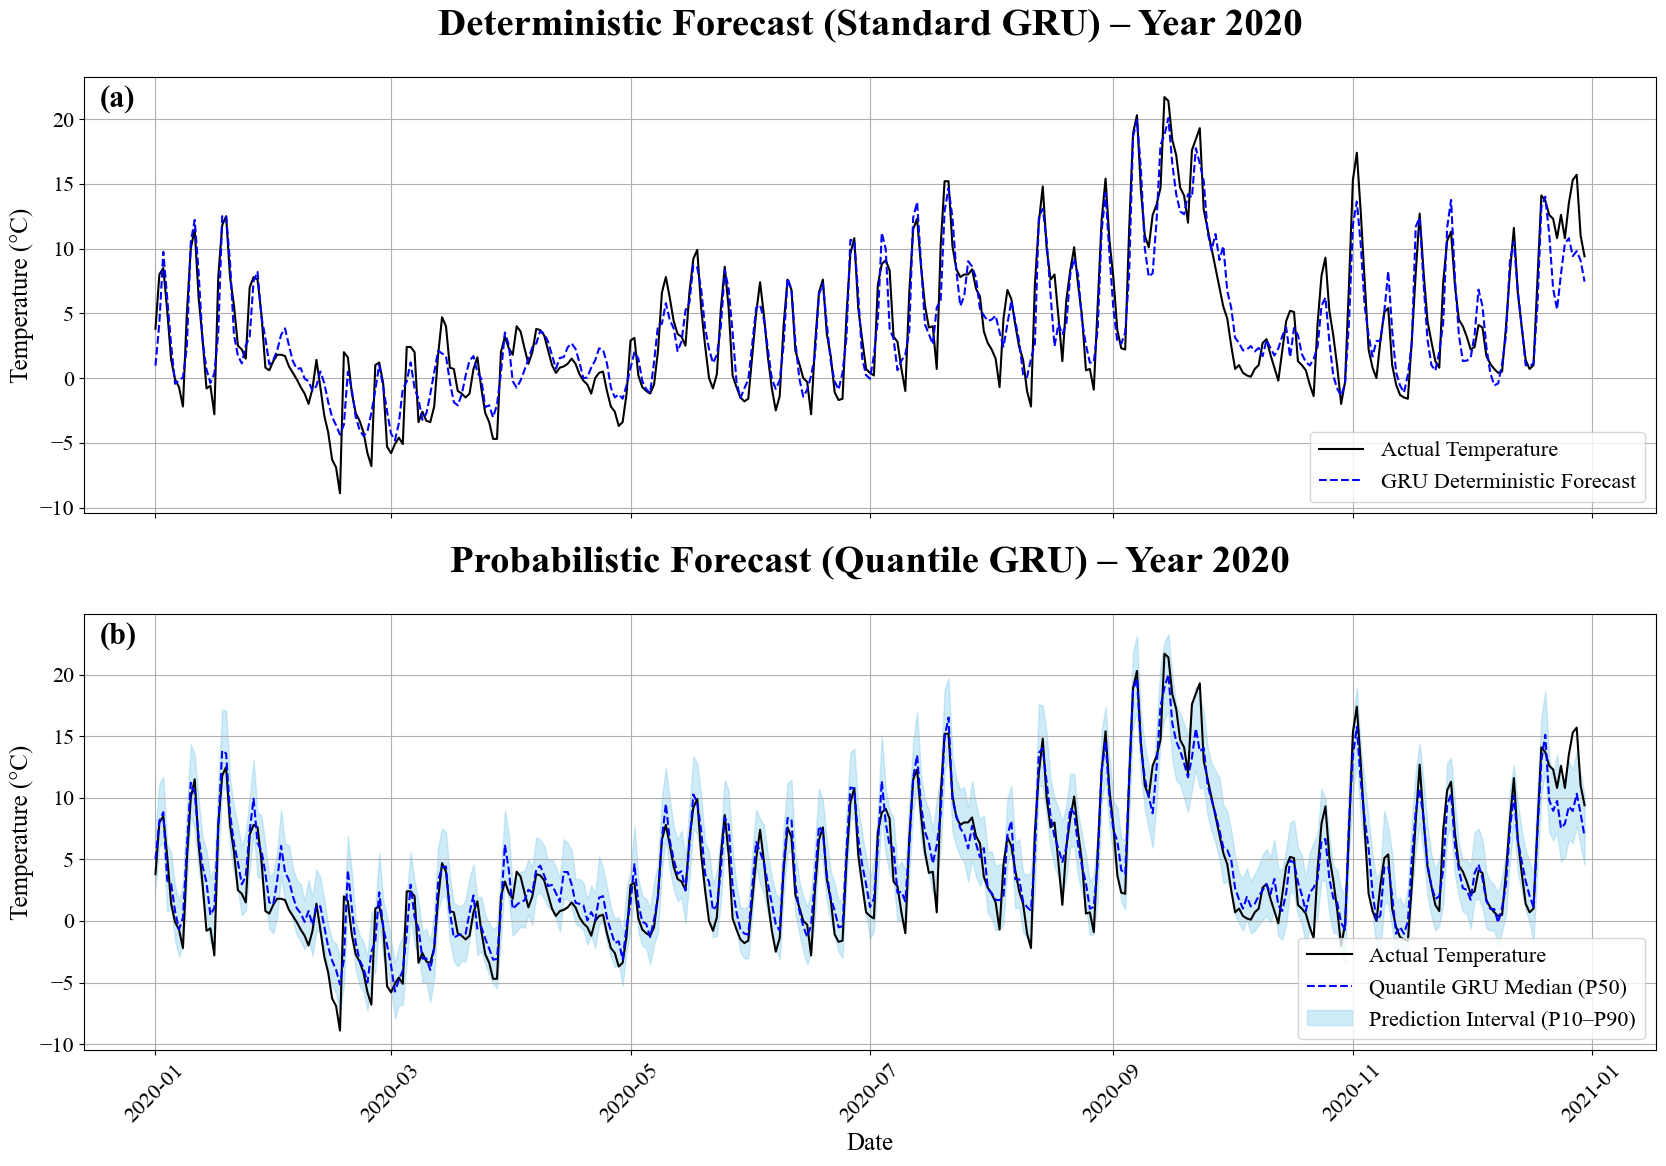

In [49]:
mpl.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 18,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "legend.fontsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# Define test start date and filter for the year 2020
test_start_date = pd.to_datetime("2020-01-01")
date_list = pd.date_range(start=test_start_date, periods=len(y3_test_actual), freq='D')

mask = (date_list >= "2020-01-01") & (date_list <= "2020-12-30")
indices = np.where(mask)[0]
date_filtered = date_list[indices]

true_vals = y3_test_actual[indices, 0].flatten()
point_vals = y3_test_pred1[indices, 0].flatten()
p10_vals = p10[indices, 0].flatten()
p50_vals = p50[indices, 0].flatten()
p90_vals = p90[indices, 0].flatten()

# Create a figure with two subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(17, 12), sharex=True)

# --- (a) Standard GRU (Deterministic Forecast)
axs[0].plot(date_filtered, true_vals, label='Actual Temperature', color='black')
axs[0].plot(date_filtered, point_vals, label='GRU Deterministic Forecast', color='blue', linestyle='--')
axs[0].set_title('Deterministic Forecast (Standard GRU) – Year 2020',
                 fontsize=28, fontweight='bold', pad=30)
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='lower right')
axs[0].grid(True)
axs[0].text(0.01, 0.93, '(a)', transform=axs[0].transAxes,
            fontsize=22, fontweight='bold')

# --- (b) Quantile GRU (Probabilistic Forecast)
axs[1].plot(date_filtered, true_vals, label='Actual Temperature', color='black')
axs[1].plot(date_filtered, p50_vals, label='Quantile GRU Median (P50)', color='blue', linestyle='--')
axs[1].fill_between(date_filtered, p10_vals, p90_vals,
                    color='skyblue', alpha=0.4, label='Prediction Interval (P10–P90)')
axs[1].set_title('Probabilistic Forecast (Quantile GRU) – Year 2020',
                 fontsize=28, fontweight='bold', pad=30)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature (°C)')
axs[1].legend(loc='lower right')
axs[1].grid(True)
axs[1].text(0.01, 0.93, '(b)', transform=axs[1].transAxes,
            fontsize=22, fontweight='bold')

# 🔧 Final adjustments
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig.savefig("forecast_with_legend_bottomright.png", dpi=300, bbox_inches='tight', format='png')


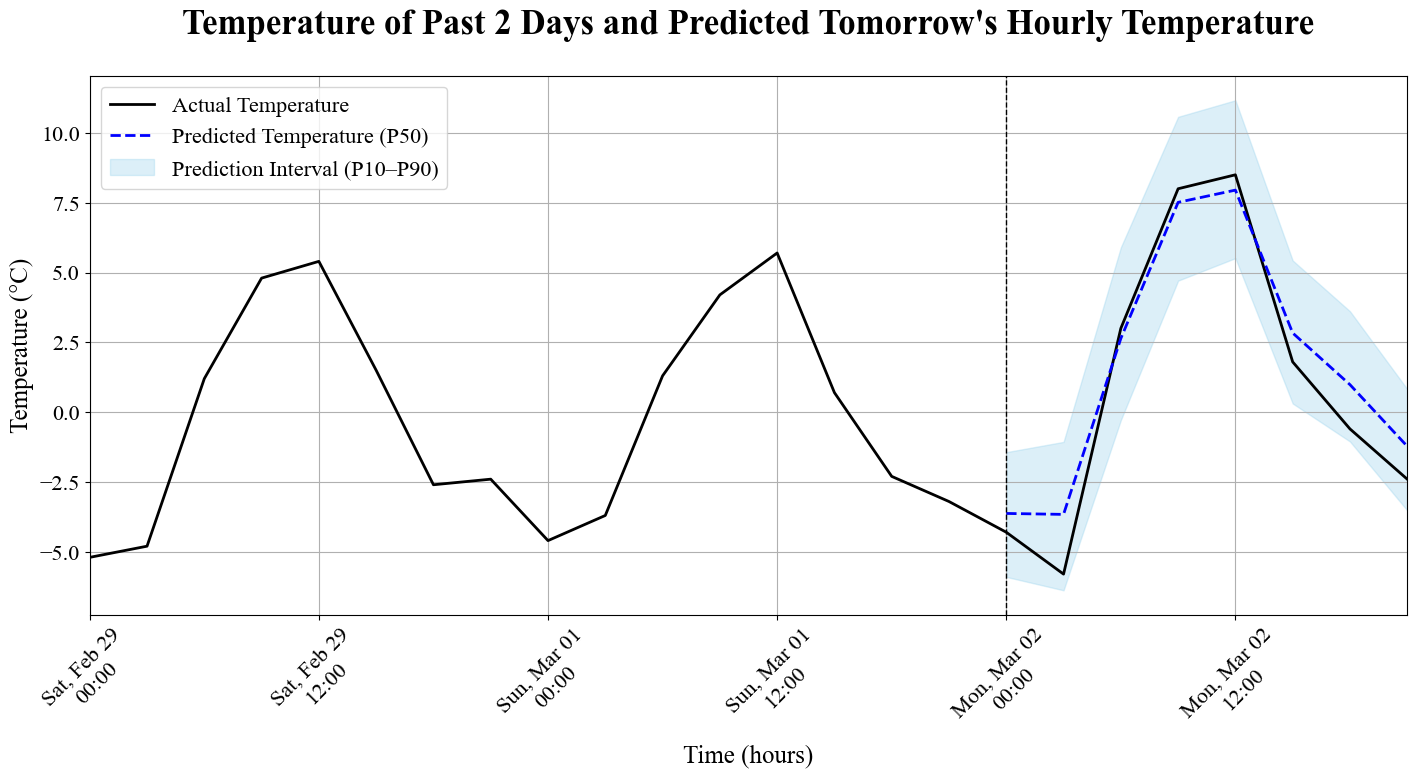

In [52]:
mpl.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 18,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "legend.fontsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# Define target day and setup
target_day = pd.to_datetime("2020-03-02")
past_days = 2
steps_per_day = 8  # 3-hourly steps: 24 / 3 = 8

# Generate timestamps from two days before to the end of target day
start_time = target_day - pd.Timedelta(days=past_days)
end_time = target_day + pd.Timedelta(days=1)
timestamps = pd.date_range(start=start_time, end=end_time, freq="3H")[:-1]

# Index calculations (assuming data starts from 2020-03-05)
start_index = (target_day - pd.to_datetime("2020-03-05")).days * steps_per_day - past_days * steps_per_day
indices_all = np.arange(start_index, start_index + steps_per_day * (past_days + 1))

# Extract actual and predicted temperature data
true_temp = y3_test_actual[indices_all, 0]
p10_temp = p10[indices_all, 0]
p50_temp = p50[indices_all, 0]
p90_temp = p90[indices_all, 0]

# Masks for past and future intervals
past_mask = timestamps < target_day
future_mask = timestamps >= target_day

# Plotting
fig, ax = plt.subplots(figsize=(17, 7))
ax.set_xlim(timestamps[0], timestamps[-1])

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a, %b %d\n%H:%M'))
plt.xticks(rotation=45)

# Plot actual temperature over entire range
ax.plot(timestamps, true_temp,
        label="Actual Temperature", color='black', linewidth=2)

# Plot P50 predicted temperatures for future only
ax.plot(timestamps[future_mask], p50_temp[future_mask],
        label="Predicted Temperature (P50)", color='blue', linestyle='--', linewidth=2)

# Fill between P10 and P90 to show uncertainty interval
ax.fill_between(timestamps[future_mask],
                p10_temp[future_mask],
                p90_temp[future_mask],
                color='#8CCDEB', alpha=0.3,
                label='Prediction Interval (P10–P90)')

# Vertical dashed line separating past and future
ax.axvline(x=target_day, color='black', linestyle='--', linewidth=1)

# Titles and labels
plt.title("Past 2 Days and Next-Day Hourly Temperature Forecast",
          fontsize=25, fontweight='bold', pad=30)
plt.xlabel("Time (Hours)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)

plt.show()
